C:\Users\ewais\AppData\Local\Programs\Python\Python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


src shape : torch.Size([16, 512, 500])
torch.Size([16, 512, 1])
src_embed shape: torch.Size([16, 512, 500])
none grad layers: []
zero grad layers: []


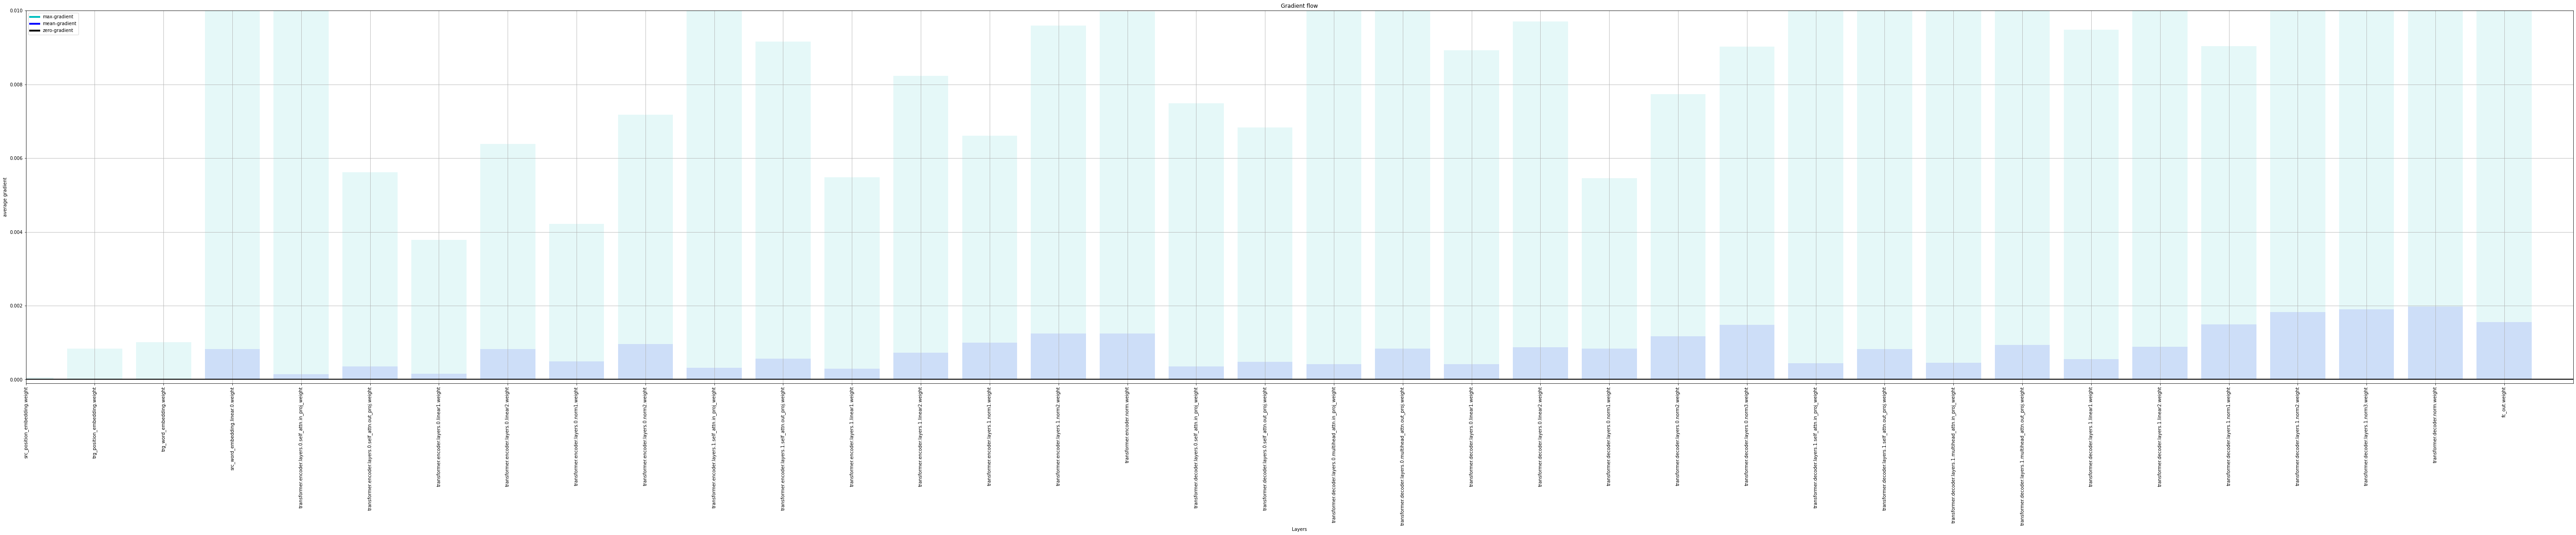


Epoch 1/1
Training Loss: 6.211007118225098


In [1]:
from model import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_grad_flow(named_parameters):
    '''
    Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow
    '''
    ave_grads = []
    max_grads= []
    layers = []
    none_grad_layers = []
    zero_grads = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            if p.grad is not None:
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
            else:
                none_grad_layers.append(n)

    print('none grad layers: {}'.format(none_grad_layers))
    print('zero grad layers: {}'.format(zero_grads))
    plt.figure(figsize=(100,15))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.0001, top=0.01) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()

params = {
    'batch_size' : 16,
    'shuffle' : True,
    'num_workers' : 4,
    'drop_last' : True
}

# NOTE: max_trg_len <= max_src_len otherwise side asset error is triggered
max_trg_len = 500 # length of all target note sequences, holds 99 notes max
max_src_len = 500
pad_idx = 434

# Define data loaders
train_path = Path(r'X:\Training Data\Model 1 Training\train')
train_data = LazierDataset(train_path, max_src_len, max_trg_len, pad_idx)
train_loader = torch.utils.data.DataLoader(train_data, **params)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training hyperparameters
learning_rate = 3e-3
batch_size = params['batch_size']

# Model hyperparameters
trg_vocab_size = 435  # <output length>
embedding_size = 512
num_heads = 8
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1
max_len = max_src_len
forward_expansion = 2048

# Tensorboard for nice plots
# writer = SummaryWriter('runs/model5')
step = 0  # how many times the model has gone through some input

# Define model
model = Transformer(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

# print(model.named_parameters)

# torch.save(model.state_dict(), 'model.pt')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# criterion = nn.CrossEntropyLoss() # Multi-class loss, when you have a many class prediction problem
criterion = nn.CrossEntropyLoss(ignore_index=434)

num_epochs = 1
model.train() # Put model in training mode, so that it knows it's parameters should be updated
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(train_loader):
        # Batches come through as a tuple defined in the return statement __getitem__ in the Dataset
        spec, notes = batch[0].to(device), batch[1].to(device)

        # forward prop
        output = model(spec, notes[..., :-1])           # Don't pass the last element into the decoder, want it to be predicted
        notes = notes[..., 1:] # .reshape(-1)           # Same for the notes

        optimizer.zero_grad()                           # Zero out the gradient so it doesn't accumulate

        # gradients should be zero here, after optimizer.zero_grad()

        loss = criterion(output.permute(0,2,1), notes)     # Calculate loss, this is output vs ground truth
        loss.backward()   # Compute loss for every node in the computation graph

        # GET THE GRADIENTS HERE
        params = list(model.parameters())
        named_params = list(model.named_parameters())
        if batch_idx > -1:
            plot_grad_flow(named_params)
            # layers = []
            # no_grad_layers = []
            # grads = []
            # weights = []
            # parameters = []
            # for n, p in named_params:
                # if not (p.requires_grad) and ('bias' not in n):
                    # no_grad_layers.append(n)
                # if (p.requires_grad) and ("bias" not in n):
                    # if p.grad is not None:
                        # layers.append(n)
                        # grads.append(p.grad)
                        # parameters.append(p)
                        # weights.append(p.data)
                    # # ave_grads.append(p.grad.abs().mean())
                    # # max_grads.append(p.grad.abs().max())
            break

        # This line to avoid the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()    # Update model parameters
        # writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1

        if batch_idx%25 == 0:
            print('\nEpoch {}, Batch {}'.format(epoch+1,batch_idx))
            print('Training Loss: {}'.format(loss.item()))
        

    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {loss.item()}')

    # print('LAYERS\n\n')
    # print(layers)
    # print('\n\nGRADS\n\n')
    # print(grads)
    # print('\n\nNo grad layers \n\n')
    # print(list(zip(layers, weights)))